In [20]:
%load_ext autoreload
%autoreload 2


import benchmark as bm

scrape = bm.TraceScrape()
scrape.scrape(25)
#scrape.save()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Obtaining Run from nexus-writer
  Response received. Processing json
Obtaining Frame from digitiser-aggregator
  Response received. Processing json
Obtaining process_kafka_message from nexus-writer
  Response received. Processing json
Obtaining process_digitiser_event_list_message from digitiser-aggregator
  Response received. Processing json
Obtaining process_frame_assembled_event_list_message from trace-to-events
  Response received. Processing json
Obtaining run_configured_simulation from simulator
  Response received. Processing json


In [3]:
#scrape.load()
scrape.make_trace_banks()
runs = scrape.get_last_n_runs(9)

9


In [ ]:

import run as bm_run
run = runs[0]
bm_run.plot_event_formation(run)
bm_run.plot_aggregation(run)
bm_run.plot_writer(run)

In [ ]:
run = runs[0]
bm_run.plot_pulse_detections(run)
bm_run.plot_pulse_correlations(run)

In [ ]:
import ipywidgets as widget

def square(frame):
    for run in runs:
        bm_run.plot_timing_correlations(run, frame)

interact = widget.interactive(square, frame = (0,149))
display(interact)


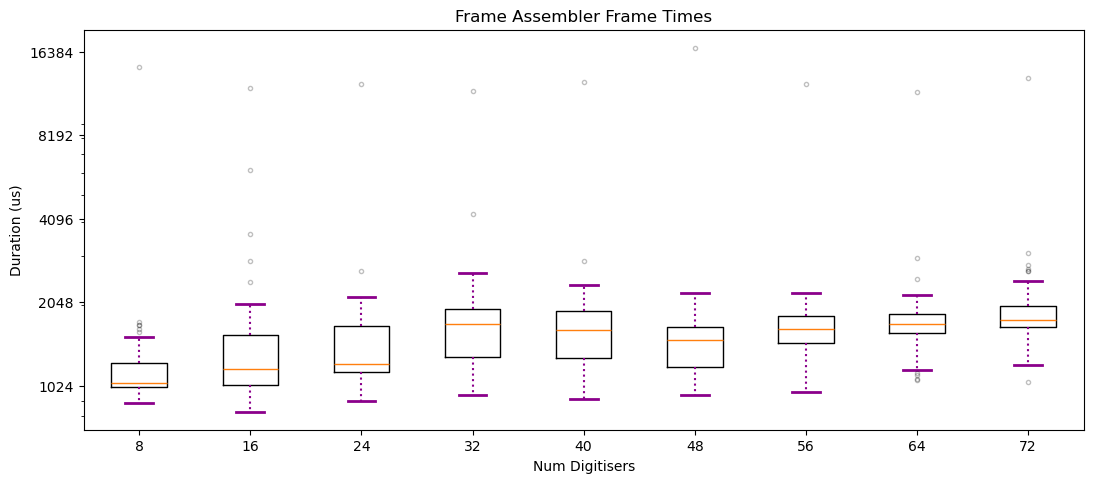

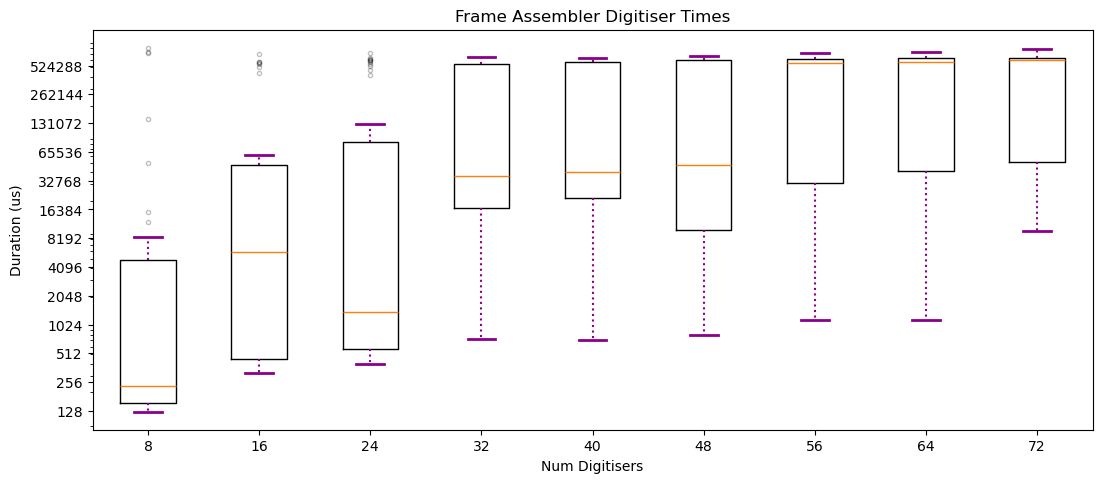

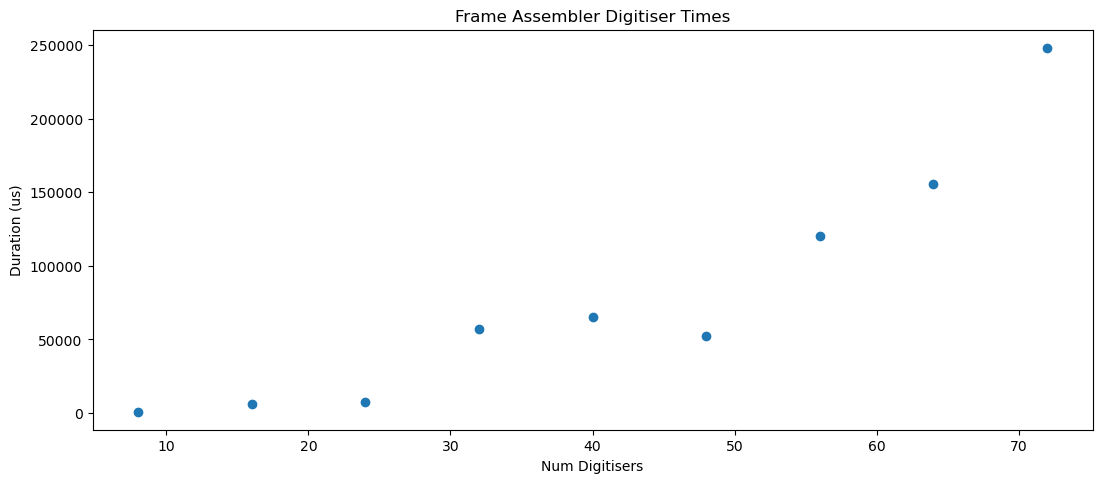

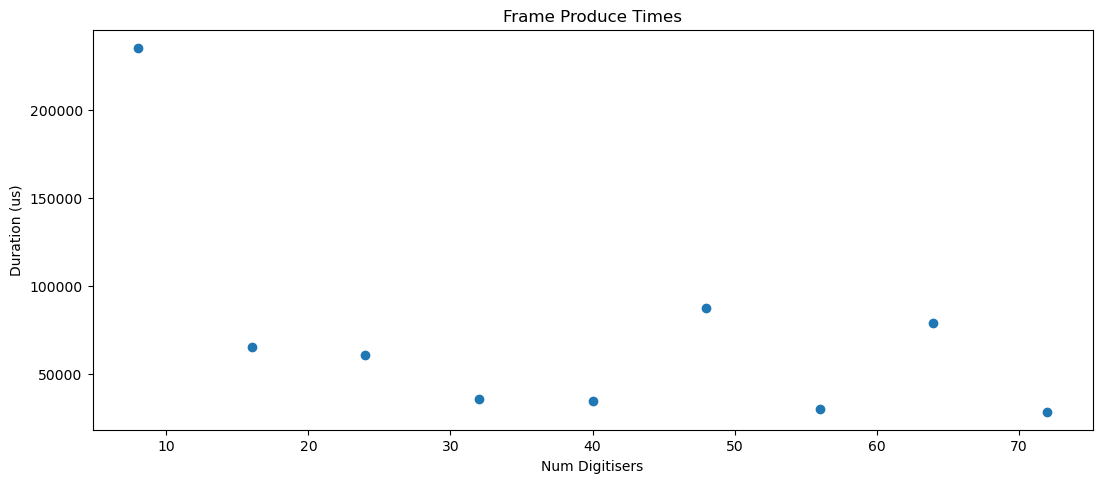

In [4]:
import run_ensemble
#run_ensemble.plot_event_formation(runs)
run_ensemble.plot_aggregation(runs)
#run_ensemble.plot_writer(runs)